# Data Workflow Project (P1)
**Name:** Christopher Aaron O'Hara

**Dataset:** OpenRCA (AIOps telemetry incidents)  

**Dataset Link:** https://github.com/microsoft/OpenRCA

**Project Repository:** https://github.com/Ohara124c41/ai-programming-foundations-project

This notebook implements a complete, reproducible AIOps data workflow.
It uses OpenRCA Telecom telemetry to demonstrate ingestion, cleaning, EDA, and visualization with a research-oriented but reproducible structure.
The workflow is designed as a foundation for later ML, deep learning, and agentic RCA modules. 


## 1) Setup

In [1]:
import importlib.util
import subprocess
import sys
import urllib.request
import warnings
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Bootstrap toggles
AUTO_INSTALL_AIF360 = True
AUTO_DOWNLOAD_DATASET = False
AUTO_DOWNLOAD_OPENRCA_TELECOM = True
AIF360_PACKAGE_SPEC = "aif360==0.6.1"
GDOWN_PACKAGE_SPEC = "gdown>=5.2.0"
DATASET_URL = ""  # Optional direct CSV URL. OpenRCA full dataset is typically downloaded manually from Google Drive.
OPENRCA_TELECOM_ZIP_GDRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"  # Folder or direct file URL.
OPENRCA_TELECOM_ZIP_FILE_ID = "1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe"  # Telecom.zip file id to avoid downloading Bank/Market.
OPENRCA_DRIVE_URL = "https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link"
OPENRCA_SYSTEM_PREFERENCE = "Telecom"
data_root_candidates = [Path("data"), Path("P1") / "data"]
DATA_ROOT = next(
    (c for c in data_root_candidates if any((c / "openrca" / "Telecom" / "telemetry").glob("*/metric/*.csv"))),
    next(
        (c for c in data_root_candidates if (c / "openrca" / "Telecom" / "query.csv").exists()),
        next((c for c in data_root_candidates if (c / "openrca").exists()), Path("data")),
    ),
)
OPENRCA_EXTRACT_DIR = DATA_ROOT / "openrca"
DOWNLOADED_OPENRCA_ZIP_PATH = DATA_ROOT / "openrca_telecom.zip"
DOWNLOADED_DATASET_PATH = DATA_ROOT / "openrca" / "Telecom" / "telemetry" / "2020_04_20" / "metric" / "metric_service.csv"
# Telecom-focused ingestion controls
COMBINE_TELECOM_METRIC_FILES = True
TELECOM_METRIC_DAY = "2020_04_20"
TELECOM_METRIC_GLOB = "metric_*.csv"
TELECOM_LOCAL_TIMEZONE = "Asia/Shanghai"
# Subset controls for faster exploratory workflow
SUBSET_ENABLED = True
SUBSET_MAX_ROWS = 50000
SUBSET_RANDOM_STATE = 42
SUBSET_STRATIFY_COLUMN = None  # Example: "service" or "fault_type" if present
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 120)
def ensure_python_package(module_name: str, package_spec: str, auto_install: bool = False) -> tuple[bool, str]:
    """Ensure a Python package is importable; optionally install it in the active kernel environment."""
    if importlib.util.find_spec(module_name) is not None:
        return True, "already_installed"
    if not auto_install:
        return False, "missing_auto_install_disabled"
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_spec])
        ok = importlib.util.find_spec(module_name) is not None
        return ok, "installed" if ok else "install_failed_import"
    except Exception as exc:
        return False, f"install_error: {exc}"
def maybe_download_dataset(url: str, output_path: Path, auto_download: bool = False) -> tuple[bool, str]:
    """Download a dataset file only when enabled and no local copy exists."""
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if output_path.exists():
        return True, "already_present"
    if not auto_download:
        return False, "download_disabled"
    if not url:
        return False, "missing_dataset_url"
    try:
        urllib.request.urlretrieve(url, output_path)
        return output_path.exists(), "downloaded"
    except Exception as exc:
        return False, f"download_error: {exc}"
def find_openrca_query_csv(base_dir: Path, system_preference: str = "Telecom") -> Path | None:
    """Find OpenRCA query.csv, preferring paths that contain the requested system name."""
    query_files = sorted(base_dir.glob("**/query.csv"), key=lambda x: str(x).lower())
    if not query_files:
        return None
    preferred = [p for p in query_files if system_preference.lower() in str(p).lower()]
    return preferred[0] if preferred else query_files[0]
def maybe_download_and_extract_openrca_zip(
    gdrive_url: str,
    telecom_zip_file_id: str,
    zip_path: Path,
    extract_dir: Path,
    auto_download: bool = False,
    system_preference: str = "Telecom",
) -> tuple[bool, str, Path | None]:
    """Download OpenRCA ZIP from Google Drive and extract query.csv files for ingestion."""
    extract_dir.mkdir(parents=True, exist_ok=True)
    existing_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if existing_query is not None:
        return True, "already_present", existing_query
    if not auto_download:
        return False, "download_disabled", None
    if not gdrive_url and not telecom_zip_file_id:
        return False, "missing_gdrive_url_or_file_id", None
    gdown_ready, gdown_status = ensure_python_package(
        module_name="gdown",
        package_spec=GDOWN_PACKAGE_SPEC,
        auto_install=True,
    )
    if not gdown_ready:
        return False, f"gdown_unavailable:{gdown_status}", None
    try:
        import gdown
    except Exception as exc:
        return False, f"gdown_import_error:{exc}", None
    try:
        zip_path.parent.mkdir(parents=True, exist_ok=True)
        if telecom_zip_file_id:
            downloaded_file = gdown.download(
                id=telecom_zip_file_id,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "telecom_zip_download_failed", None
        elif gdrive_url and "/folders/" in gdrive_url:
            return False, "folder_url_requires_telecom_file_id", None
        else:
            downloaded_file = gdown.download(
                url=gdrive_url,
                output=str(zip_path),
                quiet=False,
                fuzzy=True,
            )
            if downloaded_file is None or not zip_path.exists():
                return False, "zip_download_failed", None
    except Exception as exc:
        return False, f"zip_download_error:{exc}", None
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
    except Exception as exc:
        return False, f"zip_extract_error:{exc}", None
    extracted_query = find_openrca_query_csv(extract_dir, system_preference=system_preference)
    if extracted_query is None:
        return False, "extracted_but_query_missing", None
    return True, "downloaded_and_extracted", extracted_query
def maybe_subset_dataframe(
    df: pd.DataFrame,
    enabled: bool = True,
    max_rows: int | None = 50000,
    random_state: int = 42,
    stratify_col: str | None = None,
) -> tuple[pd.DataFrame, dict]:
    """Return a reproducible subset for EDA while tracking subset metadata."""
    metadata = {
        "subset_enabled": enabled,
        "subset_applied": False,
        "original_rows": int(len(df)),
        "subset_rows": int(len(df)),
        "stratified": False,
        "stratify_col": stratify_col,
    }
    if not enabled or max_rows is None or len(df) <= max_rows:
        return df, metadata
    if stratify_col and stratify_col in df.columns and df[stratify_col].nunique(dropna=True) > 1:
        sampled = (
            df.groupby(stratify_col, group_keys=False)
            .apply(lambda part: part.sample(n=max(1, int(round(len(part) * max_rows / len(df)))), random_state=random_state))
        )
        if len(sampled) > max_rows:
            sampled = sampled.sample(n=max_rows, random_state=random_state)
        subset = sampled.reset_index(drop=True)
        metadata["stratified"] = True
    else:
        subset = df.sample(n=max_rows, random_state=random_state).reset_index(drop=True)
    metadata["subset_applied"] = True
    metadata["subset_rows"] = int(len(subset))
    return subset, metadata
aif360_ready, aif360_status = ensure_python_package(
    module_name="aif360",
    package_spec=AIF360_PACKAGE_SPEC,
    auto_install=AUTO_INSTALL_AIF360,
)
openrca_zip_ready, openrca_zip_status, openrca_query_path = maybe_download_and_extract_openrca_zip(
    gdrive_url=OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    telecom_zip_file_id=OPENRCA_TELECOM_ZIP_FILE_ID,
    zip_path=DOWNLOADED_OPENRCA_ZIP_PATH,
    extract_dir=OPENRCA_EXTRACT_DIR,
    auto_download=AUTO_DOWNLOAD_OPENRCA_TELECOM,
    system_preference=OPENRCA_SYSTEM_PREFERENCE,
)
dataset_ready, dataset_status = maybe_download_dataset(
    url=DATASET_URL,
    output_path=DOWNLOADED_DATASET_PATH,
    auto_download=AUTO_DOWNLOAD_DATASET,
)
if openrca_query_path is not None:
    DOWNLOADED_DATASET_PATH = openrca_query_path
try:
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric
    AIF360_AVAILABLE = True
except Exception:
    AIF360_AVAILABLE = False
BOOTSTRAP_STATUS = {
    "aif360_status": aif360_status,
    "openrca_zip_status": openrca_zip_status,
    "openrca_zip_ready": openrca_zip_ready,
    "openrca_query_path": str(openrca_query_path) if openrca_query_path is not None else None,
    "dataset_status": dataset_status,
    "download_target": str(DOWNLOADED_DATASET_PATH),
    "openrca_drive_url": OPENRCA_DRIVE_URL,
    "openrca_zip_url": OPENRCA_TELECOM_ZIP_GDRIVE_URL,
    "openrca_zip_file_id": OPENRCA_TELECOM_ZIP_FILE_ID,
    "openrca_system_preference": OPENRCA_SYSTEM_PREFERENCE,
}
print("Bootstrap status:", BOOTSTRAP_STATUS)


pip install 'aif360[Reductions]'


pip install 'aif360[Reductions]'


pip install 'aif360[inFairness]'


pip install 'aif360[Reductions]'


Bootstrap status: {'aif360_status': 'already_installed', 'openrca_zip_status': 'already_present', 'openrca_zip_ready': True, 'openrca_query_path': 'P1\\data\\openrca\\Telecom\\query.csv', 'dataset_status': 'already_present', 'download_target': 'P1\\data\\openrca\\Telecom\\query.csv', 'openrca_drive_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_url': 'https://drive.google.com/drive/folders/1wGiEnu4OkWrjPxfx5ZTROnU37-5UDoPM?usp=drive_link', 'openrca_zip_file_id': '1cyOKpqyAP4fy-QiJ6a_cKuwR7D46zyVe', 'openrca_system_preference': 'Telecom'}


## 2) Ingestion

In [2]:
DATA_DIR = globals().get("DATA_ROOT", Path("data"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

system_name = str(globals().get("OPENRCA_SYSTEM_PREFERENCE", "Telecom"))
system_dir = DATA_DIR / "openrca" / system_name

df_raw = None
DATASET_PATH = None
INGESTION_MODE = None
INGESTION_DETAIL = {}

# Preferred mode: combine all metric CSVs for one telecom day.
metric_day = str(globals().get("TELECOM_METRIC_DAY", "2020_04_20"))
combine_metric_files = bool(globals().get("COMBINE_TELECOM_METRIC_FILES", True))
metric_glob = str(globals().get("TELECOM_METRIC_GLOB", "metric_*.csv"))

if combine_metric_files:
    metric_dir = system_dir / "telemetry" / metric_day / "metric"
    metric_files = sorted(metric_dir.glob(metric_glob), key=lambda x: str(x).lower())
    if metric_files:
        frames = []
        for metric_file in metric_files:
            part = pd.read_csv(metric_file, low_memory=False)
            part["metric_source"] = metric_file.stem
            part["telemetry_day"] = metric_day
            frames.append(part)
        df_raw = pd.concat(frames, ignore_index=True, sort=False)
        DATASET_PATH = metric_dir / metric_glob
        INGESTION_MODE = "combined_metric_files"
        INGESTION_DETAIL = {
            "metric_day": metric_day,
            "metric_files_loaded": len(metric_files),
            "metric_file_names": [m.name for m in metric_files],
        }

# Fallback mode: single-file selection.
if df_raw is None:
    bootstrap_dataset_path = Path(globals().get("DOWNLOADED_DATASET_PATH", system_dir / "query.csv"))
    preferred_metric_csvs = sorted(system_dir.glob("telemetry/*/metric/*.csv"), key=lambda x: str(x).lower())
    preferred_query_csvs = sorted(system_dir.glob("query.csv"), key=lambda x: str(x).lower())
    preferred_record_csvs = sorted(system_dir.glob("record.csv"), key=lambda x: str(x).lower())
    openrca_preferred_paths = [bootstrap_dataset_path] + preferred_metric_csvs + preferred_query_csvs + preferred_record_csvs
    fallback_openrca_csvs = sorted((DATA_DIR / "openrca").glob("**/*.csv"), key=lambda x: str(x).lower())
    generic_csvs = sorted([p for p in DATA_DIR.glob("*.csv")] + [p for p in Path(".").glob("*.csv")], key=lambda x: str(x).lower())
    candidate_csvs = [p for p in openrca_preferred_paths if p.exists()] + [p for p in fallback_openrca_csvs if p not in openrca_preferred_paths] + generic_csvs

    if candidate_csvs:
        DATASET_PATH = candidate_csvs[0]
        df_raw = pd.read_csv(DATASET_PATH, low_memory=False)
        INGESTION_MODE = "single_file"

if df_raw is None:
    SUBSET_METADATA = None
    print("No OpenRCA CSV found. Put files under data/openrca/{SYSTEM}/... and rerun.")
    print("Expected systems: Bank, Telecom, Market/cloudbed-1, Market/cloudbed-2")
else:
    df_raw, SUBSET_METADATA = maybe_subset_dataframe(
        df_raw,
        enabled=SUBSET_ENABLED,
        max_rows=SUBSET_MAX_ROWS,
        random_state=SUBSET_RANDOM_STATE,
        stratify_col=SUBSET_STRATIFY_COLUMN,
    )
    if "metric_source" in df_raw.columns:
        INGESTION_DETAIL["metric_source_distribution"] = df_raw["metric_source"].value_counts(dropna=False).to_dict()
    print(f"Ingestion mode: {INGESTION_MODE}")
    print(f"Loaded dataset source: {DATASET_PATH}")
    print(f"Ingestion detail: {INGESTION_DETAIL}")
    print(f"Subset metadata: {SUBSET_METADATA}")
    print(f"Shape: {df_raw.shape[0]} rows x {df_raw.shape[1]} columns")
    display(df_raw.head())

Ingestion mode: combined_metric_files
Loaded dataset source: P1\data\openrca\Telecom\telemetry\2020_04_20\metric\metric_*.csv
Ingestion detail: {'metric_day': '2020_04_20', 'metric_files_loaded': 5, 'metric_file_names': ['metric_app.csv', 'metric_container.csv', 'metric_middleware.csv', 'metric_node.csv', 'metric_service.csv'], 'metric_source_distribution': {'metric_node': 25703, 'metric_service': 14373, 'metric_middleware': 7986, 'metric_container': 1909, 'metric_app': 29}}
Subset metadata: {'subset_enabled': True, 'subset_applied': True, 'original_rows': 592921, 'subset_rows': 50000, 'stratified': False, 'stratify_col': None}
Shape: 50000 rows x 14 columns


,serviceName,startTime,avg_time,num,succee_num,succee_rate,metric_source,telemetry_day,itemid,name,bomc_id,timestamp,value,cmdb_id
0,NaN,NaN,NaN,NaN,NaN,NaN,metric_middleware,2020_04_20,1.000000e+15,keyspace_hits,ZJ-005-027,1.587332e+12,3.000000,redis_010
1,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,Disk_await,ZJ-001-096,1.587328e+12,1.000000,os_007
2,NaN,NaN,NaN,NaN,NaN,NaN,metric_service,2020_04_20,6.315160e+07,Sess_Active,ZJ-002-013,1.587318e+12,0.100000,db_005
3,NaN,NaN,NaN,NaN,NaN,NaN,metric_container,2020_04_20,1.000000e+15,container_cpu_used,ZJ-004-059,1.587325e+12,34.000000,docker_003
4,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,CPU_system_time,ZJ-001-014,1.587320e+12,0.191776,os_009


## 3) Cleaning

Before cleaning, the merged telecom telemetry contains: (1) mixed column naming conventions, (2) epoch-like time values stored as numeric floats, (3) duplicate rows, and (4) structural missingness because five different metric schemas were combined into one table.

The cleaning strategy addresses each issue explicitly: standardize names for reliable code access, deduplicate exact repeats, parse true time fields while preserving duration fields (for example `avg_time`), and apply selective imputation only to lower-missingness columns. Highly sparse source-specific columns are kept for transparency but treated as structural features rather than globally imputed variables.


In [3]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Convert columns to lowercase snake_case for reliable downstream code."""
    cleaned = df.copy()
    cleaned.columns = (
        cleaned.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("-", "_", regex=False)
    )
    return cleaned


def drop_duplicate_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Remove exact duplicate records to avoid duplicated incident evidence."""
    return df.drop_duplicates().copy()


def infer_epoch_unit(series: pd.Series) -> str | None:
    """Infer epoch unit from numeric timestamp magnitude (s/ms/us/ns)."""
    numeric = pd.to_numeric(series, errors="coerce").dropna()
    if numeric.empty:
        return None
    magnitude = numeric.abs().median()
    if magnitude >= 1e17:
        return "ns"
    if magnitude >= 1e14:
        return "us"
    if magnitude >= 1e11:
        return "ms"
    if magnitude >= 1e9:
        return "s"
    return None


def parse_time_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Parse true timestamp/date columns while leaving duration metrics (for example avg_time) numeric."""
    cleaned = df.copy()
    time_like_cols = [
        c for c in cleaned.columns
        if any(k in c for k in ["timestamp", "starttime", "endtime", "datetime", "date", "time"])
    ]
    duration_hints = ["avg_time", "latency", "duration", "elapsed", "response_time", "cost_time", "delay"]

    local_tz = globals().get("TELECOM_LOCAL_TIMEZONE", None)

    for col in time_like_cols:
        if any(hint in col for hint in duration_hints):
            continue

        numeric = pd.to_numeric(cleaned[col], errors="coerce")
        numeric_ratio = float(numeric.notna().mean())
        if numeric_ratio >= 0.95:
            unit = infer_epoch_unit(cleaned[col])
            if unit is not None:
                parsed_numeric = pd.to_datetime(numeric, unit=unit, errors="coerce", utc=True)
                if local_tz:
                    parsed_numeric = parsed_numeric.dt.tz_convert(local_tz)
                cleaned[col] = parsed_numeric.dt.tz_localize(None)
            continue

        parsed = pd.to_datetime(cleaned[col], errors="coerce", utc=True)
        if float(parsed.notna().mean()) >= 0.50:
            if local_tz:
                parsed = parsed.dt.tz_convert(local_tz)
            cleaned[col] = parsed.dt.tz_localize(None)

    return cleaned


def impute_missing_values(df: pd.DataFrame, max_missing_ratio_for_impute: float = 0.40) -> pd.DataFrame:
    """Impute non-structural missing values while preserving high-missing structural columns for honest EDA."""
    cleaned = df.copy()

    num_cols = cleaned.select_dtypes(include=[np.number]).columns
    cat_cols = cleaned.select_dtypes(include=["object", "category", "bool"]).columns

    for col in num_cols:
        if float(cleaned[col].isna().mean()) <= max_missing_ratio_for_impute:
            cleaned[col] = cleaned[col].fillna(cleaned[col].median())

    for col in cat_cols:
        if float(cleaned[col].isna().mean()) <= max_missing_ratio_for_impute and cleaned[col].isna().any():
            mode_vals = cleaned[col].mode(dropna=True)
            if len(mode_vals) > 0:
                cleaned[col] = cleaned[col].fillna(mode_vals.iloc[0])

    return cleaned


def add_telecom_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add telecom-specific derived features used for richer EDA and visualization."""
    enriched = df.copy()

    if "metric_source" in enriched.columns:
        enriched["metric_source"] = enriched["metric_source"].astype(str)

    datetime_cols = enriched.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        ref_col = datetime_cols[0]
        enriched["event_hour"] = enriched[ref_col].dt.hour
        enriched["event_dayofweek"] = enriched[ref_col].dt.dayofweek

    if "value" in enriched.columns:
        value_numeric = pd.to_numeric(enriched["value"], errors="coerce")
        enriched["value_log1p"] = np.log1p(value_numeric.clip(lower=0))

    return enriched

In [4]:
if df_raw is None:
    df_clean = None
    CLEANING_EVIDENCE = None
    STRUCTURAL_SPARSE_COLUMNS = []
    print("Cleaning skipped until dataset is available.")
else:
    df_stage = standardize_column_names(df_raw)

    duplicates_before = int(df_stage.duplicated().sum())
    df_stage = drop_duplicate_rows(df_stage)
    duplicates_after = int(df_stage.duplicated().sum())

    time_like_cols = [
        col for col in df_stage.columns
        if any(k in col for k in ["timestamp", "starttime", "endtime", "datetime", "date", "time"])
    ]
    dtype_before_parse = {col: str(df_stage[col].dtype) for col in time_like_cols}

    df_stage = parse_time_columns(df_stage)

    parsed_time_cols = [
        col for col in time_like_cols
        if "datetime64" not in dtype_before_parse.get(col, "")
        and "datetime64" in str(df_stage[col].dtype)
    ]

    num_cols = df_stage.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df_stage.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    eligible_num_cols = [col for col in num_cols if float(df_stage[col].isna().mean()) <= 0.40]
    eligible_cat_cols = [col for col in cat_cols if float(df_stage[col].isna().mean()) <= 0.40]
    eligible_impute_cols = eligible_num_cols + eligible_cat_cols

    missing_before_impute = int(df_stage[eligible_impute_cols].isna().sum().sum()) if eligible_impute_cols else 0

    df_stage = impute_missing_values(df_stage)

    missing_after_impute = int(df_stage[eligible_impute_cols].isna().sum().sum()) if eligible_impute_cols else 0
    imputed_values = int(missing_before_impute - missing_after_impute)

    df_clean = add_telecom_derived_features(df_stage)

    structural_threshold = 0.95
    structural_sparse_mask = df_clean.isna().mean() >= structural_threshold
    STRUCTURAL_SPARSE_COLUMNS = structural_sparse_mask[structural_sparse_mask].index.tolist()

    structural_sparse_report = (
        df_clean[STRUCTURAL_SPARSE_COLUMNS].isna().mean().mul(100).rename("missing_pct").to_frame().sort_values("missing_pct", ascending=False)
        if STRUCTURAL_SPARSE_COLUMNS else pd.DataFrame(columns=["missing_pct"])
    )

    CLEANING_EVIDENCE = {
        "rows_before_cleaning": int(len(df_raw)),
        "rows_after_cleaning": int(len(df_clean)),
        "duplicates_removed": int(duplicates_before - duplicates_after),
        "time_columns_candidate_count": int(len(time_like_cols)),
        "time_columns_parsed_to_datetime": int(len(parsed_time_cols)),
        "eligible_imputation_columns": int(len(eligible_impute_cols)),
        "values_imputed": int(imputed_values),
        "structural_sparse_columns_count": int(len(STRUCTURAL_SPARSE_COLUMNS)),
        "structural_sparse_threshold_pct": float(structural_threshold * 100),
    }

    print("Cleaning complete.")
    print(f"Cleaned shape: {df_clean.shape[0]} rows x {df_clean.shape[1]} columns")
    print("Cleaning evidence:", CLEANING_EVIDENCE)
    if STRUCTURAL_SPARSE_COLUMNS:
        print("Structural sparse columns kept (for schema transparency):", STRUCTURAL_SPARSE_COLUMNS)
        display(structural_sparse_report)
    display(df_clean.head())



Cleaning complete.
Cleaned shape: 50000 rows x 17 columns
Cleaning evidence: {'rows_before_cleaning': 50000, 'rows_after_cleaning': 50000, 'duplicates_removed': 0, 'time_columns_candidate_count': 3, 'time_columns_parsed_to_datetime': 1, 'eligible_imputation_columns': 7, 'values_imputed': 325, 'structural_sparse_columns_count': 6, 'structural_sparse_threshold_pct': 95.0}
Structural sparse columns kept (for schema transparency): ['servicename', 'starttime', 'avg_time', 'num', 'succee_num', 'succee_rate']


,missing_pct
servicename,99.942
starttime,99.942
avg_time,99.942
num,99.942
succee_num,99.942
succee_rate,99.942


,servicename,starttime,avg_time,num,succee_num,succee_rate,metric_source,telemetry_day,itemid,name,bomc_id,timestamp,value,cmdb_id,event_hour,event_dayofweek,value_log1p
0,NaN,NaN,NaN,NaN,NaN,NaN,metric_middleware,2020_04_20,1.000000e+15,keyspace_hits,ZJ-005-027,2020-04-20 05:33:32,3.000000,redis_010,5.0,0.0,1.386294
1,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,Disk_await,ZJ-001-096,2020-04-20 04:31:02,1.000000,os_007,4.0,0.0,0.693147
2,NaN,NaN,NaN,NaN,NaN,NaN,metric_service,2020_04_20,6.315160e+07,Sess_Active,ZJ-002-013,2020-04-20 01:31:49,0.100000,db_005,1.0,0.0,0.095310
3,NaN,NaN,NaN,NaN,NaN,NaN,metric_container,2020_04_20,1.000000e+15,container_cpu_used,ZJ-004-059,2020-04-20 03:32:50,34.000000,docker_003,3.0,0.0,3.555348
4,NaN,NaN,NaN,NaN,NaN,NaN,metric_node,2020_04_20,1.000000e+15,CPU_system_time,ZJ-001-014,2020-04-20 02:18:47,0.191776,os_009,2.0,0.0,0.175445


**Handling of 99.94% null columns:** Columns with very high missingness are retained in the cleaned dataframe to preserve source-schema transparency, but they are not globally imputed. In downstream EDA statistics and projections, coverage thresholds are applied so these fields do not dominate model-oriented summaries. This avoids fabricating values for source-specific attributes that were never observed for most rows.


## 4) Exploratory Data Analysis (EDA)

In [5]:
def generate_eda_report(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """Build expanded EDA artifacts: quality profile, correlation, moments (mean/skew/kurtosis), and source-level summaries."""
    try:
        summary_stats = df.describe(include="all", datetime_is_numeric=True).transpose()
    except TypeError:
        # Compatibility fallback for pandas versions that do not support datetime_is_numeric.
        summary_stats = df.describe(include="all").transpose()

    missingness = (
        df.isna().sum()
        .rename("missing_count")
        .to_frame()
        .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
        .sort_values("missing_count", ascending=False)
    )

    cardinality = (
        df.nunique(dropna=True)
        .rename("unique_values")
        .to_frame()
        .sort_values("unique_values", ascending=False)
    )

    numeric_df = df.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.loc[:, numeric_df.notna().mean() >= 0.60]

    if numeric_df.empty:
        numeric_corr = pd.DataFrame()
        numeric_moments = pd.DataFrame()
    else:
        numeric_corr = numeric_df.corr(numeric_only=True)
        numeric_moments = pd.DataFrame(
            {
                "count": numeric_df.count(),
                "mean": numeric_df.mean(),
                "median": numeric_df.median(),
                "std": numeric_df.std(),
                "variance": numeric_df.var(),
                "skewness": numeric_df.skew(),
                "kurtosis": numeric_df.kurtosis(),
                "min": numeric_df.min(),
                "q1": numeric_df.quantile(0.25),
                "q3": numeric_df.quantile(0.75),
                "max": numeric_df.max(),
            }
        )
        numeric_moments["iqr"] = numeric_moments["q3"] - numeric_moments["q1"]
        numeric_moments["cv"] = numeric_moments["std"] / numeric_moments["mean"].replace(0, np.nan)
        numeric_moments = numeric_moments.sort_values("std", ascending=False)

    if "metric_source" in df.columns:
        source_breakdown = (
            df["metric_source"].fillna("unknown").astype(str).value_counts().rename_axis("metric_source").to_frame("rows")
        )
    else:
        source_breakdown = pd.DataFrame(columns=["rows"])

    if "metric_source" in df.columns and "value" in df.columns:
        source_value_stats = (
            df.assign(value_numeric=pd.to_numeric(df["value"], errors="coerce"))
            .groupby("metric_source")["value_numeric"]
            .agg(["count", "mean", "std", "min", "max"])
            .rename(columns={"count": "value_count", "mean": "value_mean", "std": "value_std", "min": "value_min", "max": "value_max"})
            .sort_values("value_count", ascending=False)
        )
    else:
        source_value_stats = pd.DataFrame(columns=["value_count", "value_mean", "value_std", "value_min", "value_max"])

    datetime_cols = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
    if datetime_cols:
        time_coverage = pd.DataFrame(
            {
                "column": datetime_cols,
                "min_time": [df[c].min() for c in datetime_cols],
                "max_time": [df[c].max() for c in datetime_cols],
                "unique_timestamps": [df[c].nunique(dropna=True) for c in datetime_cols],
            }
        )
    else:
        time_coverage = pd.DataFrame(columns=["column", "min_time", "max_time", "unique_timestamps"])

    return {
        "summary_stats": summary_stats,
        "missingness": missingness,
        "cardinality": cardinality,
        "numeric_corr": numeric_corr,
        "numeric_moments": numeric_moments,
        "source_breakdown": source_breakdown,
        "source_value_stats": source_value_stats,
        "time_coverage": time_coverage,
    }

In [6]:
if df_clean is None:
    eda_report = None
    print("EDA skipped until dataset is available.")
else:
    eda_report = generate_eda_report(df_clean)
    print("Summary statistics (top 12 rows):")
    display(eda_report["summary_stats"].head(12))
    print("Missingness (top 12 rows):")
    display(eda_report["missingness"].head(12))
    print("Cardinality (top 12 rows):")
    display(eda_report["cardinality"].head(12))
    print("Numeric moments (mean/std/skewness/kurtosis, top 12 by std):")
    display(eda_report["numeric_moments"].head(12))
    print("Metric source breakdown:")
    display(eda_report["source_breakdown"])
    print("Metric source value stats:")
    display(eda_report["source_value_stats"])
    print("Datetime coverage:")
    display(eda_report["time_coverage"])

Summary statistics (top 12 rows):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
servicename,29,1,osb_001,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starttime,29.0,NaN,NaN,NaN,1587323145517.241455,1587312120000.0,1587318000000.0,1587322980000.0,1587329100000.0,1587333300000.0,6843639.166725
avg_time,29.0,NaN,NaN,NaN,0.490948,0.4183,0.4584,0.4807,0.5171,0.6409,0.050196
num,29.0,NaN,NaN,NaN,506.413793,359.0,452.0,506.0,567.0,615.0,69.658615
succee_num,29.0,NaN,NaN,NaN,506.413793,359.0,452.0,506.0,567.0,615.0,69.658615
succee_rate,29.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0
metric_source,50000,5,metric_node,25703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
telemetry_day,50000,1,2020_04_20,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itemid,50000.0,NaN,NaN,NaN,783960010910483.875,48717836.0,999999996381418.0,999999996431772.0,999999996508318.0,999999998651475.0,411545967802036.8125
name,50000,128,Disk_io_util,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missingness (top 12 rows):


,missing_count,missing_pct
servicename,49971,99.942
avg_time,49971,99.942
num,49971,99.942
succee_num,49971,99.942
succee_rate,49971,99.942
starttime,49971,99.942
timestamp,29,0.058
event_dayofweek,29,0.058
event_hour,29,0.058
cmdb_id,0,0.000


Cardinality (top 12 rows):


,unique_values
timestamp,17072
value_log1p,15380
value,15380
itemid,2428
name,128
bomc_id,128
cmdb_id,55
succee_num,29
starttime,29
num,29


Numeric moments (mean/std/skewness/kurtosis, top 12 by std):


,count,mean,median,std,variance,skewness,kurtosis,min,q1,q3,max,iqr,cv
itemid,50000,7.839600e+14,1.000000e+15,4.115460e+14,1.693701e+29,-1.380022,-0.095542,48717836.0,1.000000e+15,1.000000e+15,1.000000e+15,126900.000000,0.524958
value,50000,6.183931e+07,5.800000e-01,5.420481e+08,2.938161e+17,10.823207,130.766866,0.0,0.000000e+00,3.199201e+01,8.000000e+09,31.992012,8.765429
value_log1p,50000,2.338625e+00,4.574248e-01,4.151096e+00,1.723160e+01,2.837122,8.897365,0.0,0.000000e+00,3.496265e+00,2.280271e+01,3.496265,1.775016
event_hour,49971,2.489984e+00,2.000000e+00,1.712131e+00,2.931394e+00,0.004384,-1.271832,0.0,1.000000e+00,4.000000e+00,5.000000e+00,3.000000,0.687607
event_dayofweek,49971,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN


Metric source breakdown:


,rows
metric_source,
metric_node,25703
metric_service,14373
metric_middleware,7986
metric_container,1909
metric_app,29


Metric source value stats:


,value_count,value_mean,value_std,value_min,value_max
metric_source,,,,,
metric_node,25703,9.998159e+02,1.952488e+04,0.00,6.178360e+05
metric_service,14373,1.085494e+03,2.178980e+04,0.00,9.114520e+05
metric_middleware,7986,3.871681e+08,1.309118e+09,0.00,8.000000e+09
metric_container,1909,1.003562e+01,2.331906e+01,0.00,1.010000e+02
metric_app,29,5.800000e-01,0.000000e+00,0.58,5.800000e-01


Datetime coverage:


,column,min_time,max_time,unique_timestamps
0,timestamp,2020-04-20 00:00:01,2020-04-20 05:59:59,17072


### EDA Statistical Validation (Tabular)
This section validates distribution-shape conclusions using explicit tables, not only visual summaries.

In [7]:
if eda_report is None or eda_report["numeric_moments"].empty:
    moment_validation = None
    print("Moment validation skipped: numeric moments are unavailable.")
else:
    cols = ["count", "mean", "std", "variance", "skewness", "kurtosis", "iqr", "cv"]
    moment_validation = eda_report["numeric_moments"][cols].copy()
    moment_validation = moment_validation.sort_values(["kurtosis", "skewness"], ascending=False)

    print("Distribution-shape validation table (sorted by kurtosis, then skewness):")
    display(moment_validation)

    focus_features = [c for c in ["value", "value_log1p", "event_hour", "itemid", "event_dayofweek"] if c in moment_validation.index]
    if focus_features:
        print("Focused features used in interpretation:")
        display(moment_validation.loc[focus_features])


Distribution-shape validation table (sorted by kurtosis, then skewness):


,count,mean,std,variance,skewness,kurtosis,iqr,cv
value,50000,6.183931e+07,5.420481e+08,2.938161e+17,10.823207,130.766866,31.992012,8.765429
value_log1p,50000,2.338625e+00,4.151096e+00,1.723160e+01,2.837122,8.897365,3.496265,1.775016
event_dayofweek,49971,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
itemid,50000,7.839600e+14,4.115460e+14,1.693701e+29,-1.380022,-0.095542,126900.000000,0.524958
event_hour,49971,2.489984e+00,1.712131e+00,2.931394e+00,0.004384,-1.271832,3.000000,0.687607


Focused features used in interpretation:


,count,mean,std,variance,skewness,kurtosis,iqr,cv
value,50000,6.183931e+07,5.420481e+08,2.938161e+17,10.823207,130.766866,31.992012,8.765429
value_log1p,50000,2.338625e+00,4.151096e+00,1.723160e+01,2.837122,8.897365,3.496265,1.775016
event_hour,49971,2.489984e+00,1.712131e+00,2.931394e+00,0.004384,-1.271832,3.000000,0.687607
itemid,50000,7.839600e+14,4.115460e+14,1.693701e+29,-1.380022,-0.095542,126900.000000,0.524958
event_dayofweek,49971,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN


In [8]:
if df_clean is None:
    stats_summary = None
    covariance_matrix = None
    print("Summary stats skipped: dataset missing.")
else:
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        stats_summary = None
        covariance_matrix = None
        print("Summary stats skipped: no numeric columns available.")
    else:
        numeric_frame = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)

        stats_summary = pd.DataFrame({
            "count": numeric_frame.count(),
            "non_null_pct": numeric_frame.notna().mean() * 100,
            "mean": numeric_frame.mean(),
            "median": numeric_frame.median(),
            "std": numeric_frame.std(ddof=1),
            "variance": numeric_frame.var(ddof=1),
            "min": numeric_frame.min(),
            "max": numeric_frame.max(),
        })
        stats_summary["range"] = stats_summary["max"] - stats_summary["min"]
        stats_summary["cv"] = np.where(
            np.isclose(stats_summary["mean"], 0),
            np.nan,
            stats_summary["std"] / stats_summary["mean"].abs(),
        )

        print("Mean/median/std/variance/range/CV table:")
        display(stats_summary.sort_values("variance", ascending=False))

        cov_cols = [
            col for col in numeric_frame.columns
            if numeric_frame[col].notna().mean() >= 0.60 and numeric_frame[col].nunique(dropna=True) > 1
        ]

        if len(cov_cols) < 2:
            covariance_matrix = None
            print("Covariance matrix skipped: fewer than two sufficiently complete numeric columns.")
        else:
            cov_frame = numeric_frame[cov_cols].copy()
            for col in cov_frame.columns:
                cov_frame[col] = cov_frame[col].fillna(cov_frame[col].median())

            covariance_matrix = cov_frame.cov()
            if covariance_matrix.shape[0] > 10:
                keep_cols = stats_summary.loc[cov_cols].sort_values("variance", ascending=False).head(10).index
                covariance_matrix = covariance_matrix.loc[keep_cols, keep_cols]

            print("Covariance matrix (numeric features with >=60% non-null coverage):")
            display(covariance_matrix)



Mean/median/std/variance/range/CV table:


,count,non_null_pct,mean,median,std,variance,min,max,range,cv
itemid,50000,100.000,7.839600e+14,1.000000e+15,4.115460e+14,1.693701e+29,4.871784e+07,1.000000e+15,9.999999e+14,0.524958
value,50000,100.000,6.183931e+07,5.800000e-01,5.420481e+08,2.938161e+17,0.000000e+00,8.000000e+09,8.000000e+09,8.765429
starttime,29,0.058,1.587323e+12,1.587323e+12,6.843639e+06,4.683540e+13,1.587312e+12,1.587333e+12,2.118000e+07,0.000004
num,29,0.058,5.064138e+02,5.060000e+02,6.965862e+01,4.852323e+03,3.590000e+02,6.150000e+02,2.560000e+02,0.137553
succee_num,29,0.058,5.064138e+02,5.060000e+02,6.965862e+01,4.852323e+03,3.590000e+02,6.150000e+02,2.560000e+02,0.137553
value_log1p,50000,100.000,2.338625e+00,4.574248e-01,4.151096e+00,1.723160e+01,0.000000e+00,2.280271e+01,2.280271e+01,1.775016
event_hour,49971,99.942,2.489984e+00,2.000000e+00,1.712131e+00,2.931394e+00,0.000000e+00,5.000000e+00,5.000000e+00,0.687607
avg_time,29,0.058,4.909483e-01,4.807000e-01,5.019573e-02,2.519611e-03,4.183000e-01,6.409000e-01,2.226000e-01,0.102242
succee_rate,29,0.058,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000
event_dayofweek,49971,99.942,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN


Covariance matrix (numeric features with >=60% non-null coverage):


,itemid,value,event_hour,value_log1p
itemid,1.693701e+29,1.335972e+22,1.734823e+12,1.378862e+14
value,1.335972e+22,2.938161e+17,2.948643e+06,1.223986e+09
event_hour,1.734823e+12,2.948643e+06,2.929833e+00,-3.342373e-03
value_log1p,1.378862e+14,1.223986e+09,-3.342373e-03,1.723160e+01


**Statistical takeaway:** The numeric profile is dominated by heavy-tailed `value` behavior (very high skewness/kurtosis), while `value_log1p` improves but does not fully normalize shape. `event_hour` is comparatively stable, and covariance on high-coverage features shows that scale-heavy metrics can dominate variance structure. This supports robust scaling/transform choices and source-aware thresholds in later RCA modeling.

## 5) Visualizations (Telecom-First)

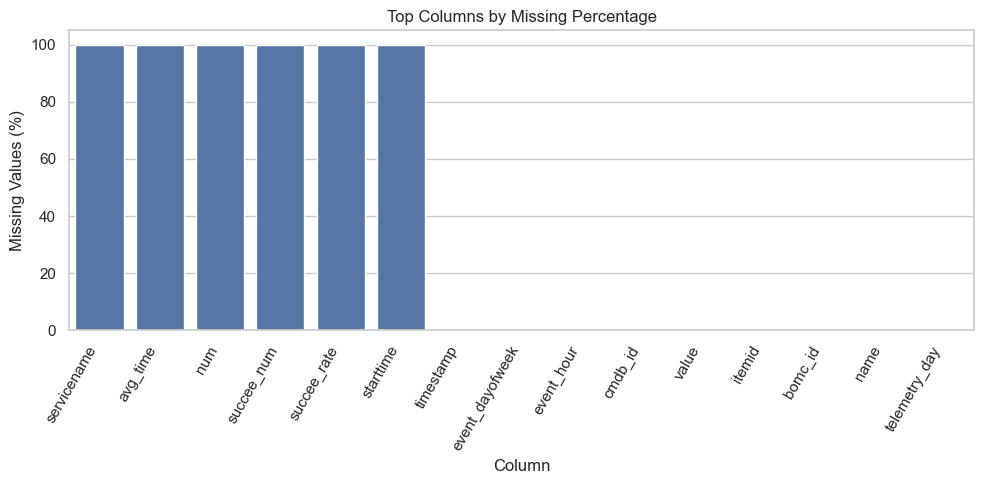

In [9]:
if eda_report is not None:
    top_missing = eda_report["missingness"].head(15).reset_index().rename(columns={"index": "column"})
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_missing, x="column", y="missing_pct")
    plt.title("Top Columns by Missing Percentage")
    plt.xlabel("Column")
    plt.ylabel("Missing Values (%)")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 1 skipped: missing EDA report.")

**Figure 1 interpretation:** Missingness is strongly structural in this merged Telecom frame. Service-level fields (`servicename`, `starttime`, `avg_time`, `num`, `succee_num`, `succee_rate`) are each missing in 49,971 of 50,000 rows (99.942%), while shared telemetry fields (`cmdb_id`, `value`, `itemid`, `bomc_id`, `name`, `telemetry_day`) are effectively complete. This indicates schema mixing across metric tables rather than random data loss.


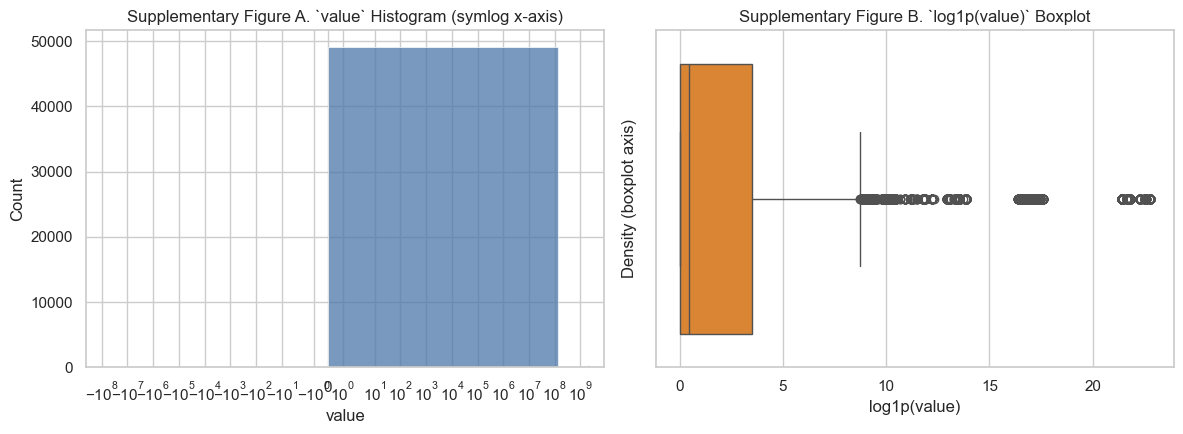

In [10]:
if df_clean is None or "value" not in df_clean.columns:
    print("Supplementary distribution plot skipped: missing `value` column.")
else:
    value_series = pd.to_numeric(df_clean["value"], errors="coerce").dropna()
    if value_series.shape[0] < 10:
        print("Supplementary distribution plot skipped: not enough numeric `value` records.")
    else:
        value_log = np.log1p(value_series.clip(lower=0))
        fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
        sns.histplot(value_series, bins=60, ax=axes[0], color="#4C78A8")
        axes[0].set_xscale("symlog")
        axes[0].set_title("Supplementary Figure A. `value` Histogram (symlog x-axis)")
        axes[0].set_xlabel("value")
        axes[0].set_ylabel("Count")
        sns.boxplot(x=value_log, ax=axes[1], color="#F58518")
        axes[1].set_title("Supplementary Figure B. `log1p(value)` Boxplot")
        axes[1].set_xlabel("log1p(value)")
        axes[1].set_ylabel("Density (boxplot axis)")
        plt.tight_layout()
        plt.show()


**Supplementary distribution interpretation:** The raw `value` histogram is heavily right-skewed, with most observations concentrated near low values and a long high-value tail. The `log1p(value)` boxplot compresses the extreme tail but still shows broad spread, supporting the earlier skewness/kurtosis findings and the use of robust transformations for downstream modeling.


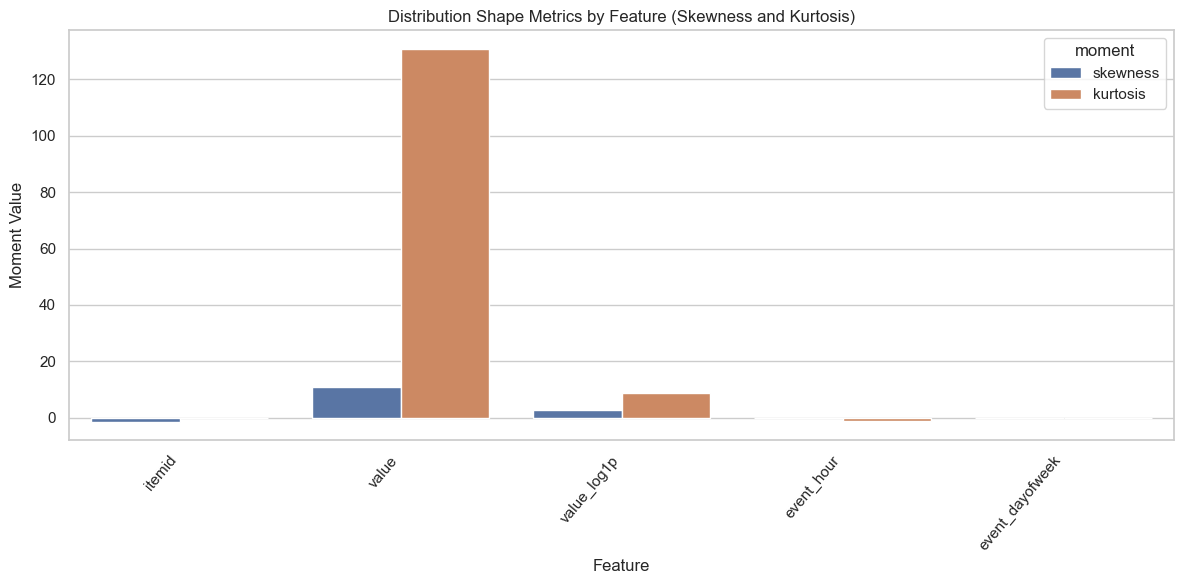

In [11]:
if eda_report is not None and not eda_report["numeric_moments"].empty:
    shape_stats = (
        eda_report["numeric_moments"][["skewness", "kurtosis"]]
        .reset_index()
        .rename(columns={"index": "feature"})
        .head(12)
        .melt(id_vars="feature", var_name="moment", value_name="value")
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(data=shape_stats, x="feature", y="value", hue="moment")
    plt.title("Distribution Shape Metrics by Feature (Skewness and Kurtosis)")
    plt.xlabel("Feature")
    plt.ylabel("Moment Value")
    plt.xticks(rotation=50, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Visualization 2 skipped: no numeric moments available.")

**Figure 2 interpretation:** The bar chart is a visual summary only; the tabular validation cell confirms the exact values used for interpretation. Specifically, `value` remains strongly heavy-tailed (`skewness` about 10.82, `kurtosis` about 130.77), while `value_log1p` reduces but does not remove tail-heaviness (`skewness` about 2.84, `kurtosis` about 8.90). `event_hour` is near-symmetric with negative kurtosis, and `event_dayofweek` is constant in this slice.


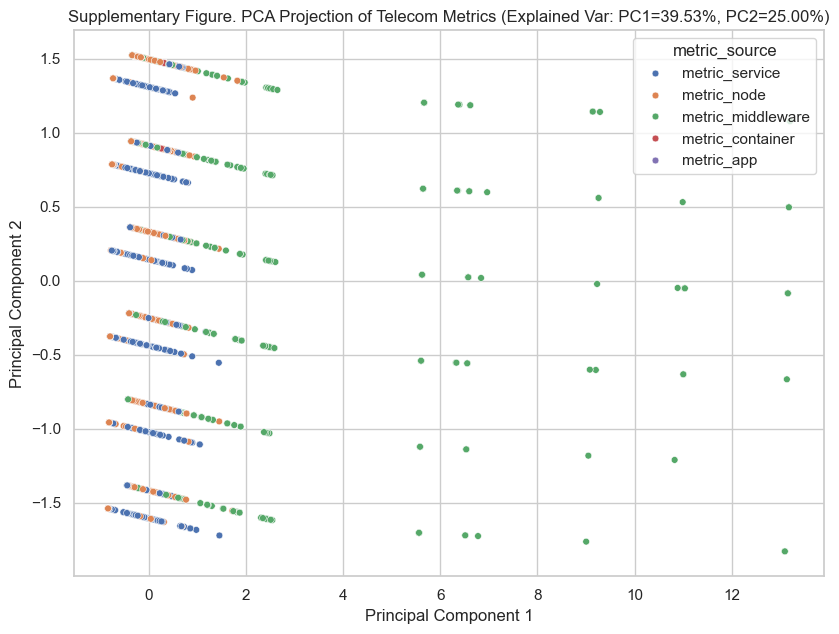

In [12]:
if df_clean is None:
    pca_frame = None
    print("Supplementary PCA figure skipped: dataset missing.")
else:
    numeric_df = df_clean.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
    numeric_df = numeric_df.loc[:, numeric_df.notna().mean() >= 0.40]
    numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]

    if numeric_df.shape[0] < 10 or numeric_df.shape[1] < 2:
        pca_frame = None
        print("Supplementary PCA figure skipped: need at least 10 rows and 2 informative numeric features.")
    else:
        sample_n = min(5000, len(numeric_df))
        sampled_numeric = numeric_df.sample(n=sample_n, random_state=42)
        imputer = SimpleImputer(strategy="median")
        X_imputed = imputer.fit_transform(sampled_numeric)

        if np.isnan(X_imputed).any():
            pca_frame = None
            print("Supplementary PCA figure skipped: NaN values remain after imputation.")
        else:
            X = StandardScaler().fit_transform(X_imputed)
            pca = PCA(n_components=2)
            components = pca.fit_transform(X)
            explained = pca.explained_variance_ratio_

            pca_frame = pd.DataFrame({"pc1": components[:, 0], "pc2": components[:, 1]}, index=sampled_numeric.index)

            hue_col = None
            label_candidates = [
                "metric_source", "cmdb_id", "name", "servicename", "label", "is_anomaly", "anomaly", "incident", "fault_type", "root_cause_service", "service"
            ]
            for col in label_candidates:
                if col in df_clean.columns and df_clean[col].nunique(dropna=True) <= 10:
                    hue_col = col
                    break

            plt.figure(figsize=(8.5, 6.5))
            if hue_col is None:
                sns.scatterplot(data=pca_frame, x="pc1", y="pc2", s=24)
            else:
                pca_frame[hue_col] = df_clean.loc[pca_frame.index, hue_col].astype(str)
                sns.scatterplot(data=pca_frame, x="pc1", y="pc2", hue=hue_col, s=24)
            plt.title(f"Supplementary Figure. PCA Projection of Telecom Metrics (Explained Var: PC1={explained[0]:.2%}, PC2={explained[1]:.2%})")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            plt.tight_layout()
            plt.show()


**Supplementary PCA interpretation:** PCA adds a linear baseline view before t-SNE. It summarizes variance along orthogonal axes and helps verify whether major source-driven structure is visible with a simpler projection method before relying on nonlinear embedding.

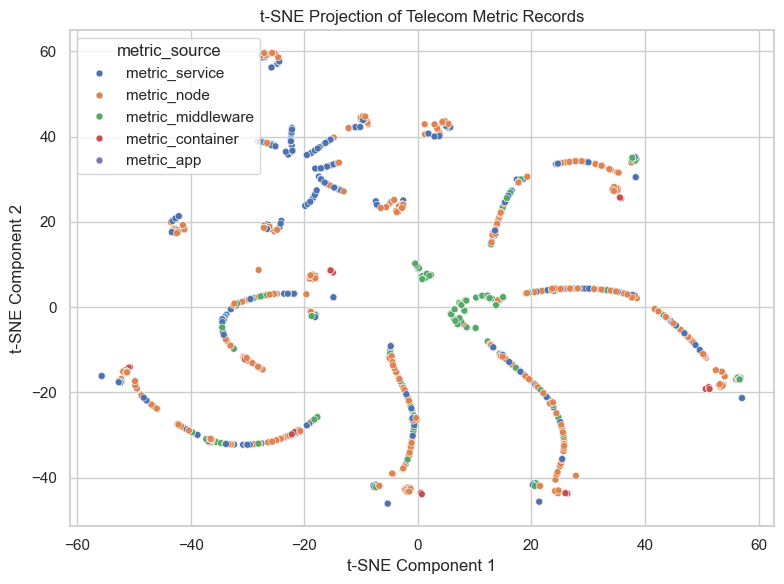

In [13]:
if df_clean is None:
    tsne_frame = None
    print("Visualization 3 skipped: dataset missing.")
else:
    numeric_df = df_clean.select_dtypes(include=[np.number]).copy()
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
    numeric_df = numeric_df.loc[:, numeric_df.notna().mean() >= 0.40]
    numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]

    if numeric_df.shape[0] < 10 or numeric_df.shape[1] < 2:
        tsne_frame = None
        print("Visualization 3 skipped: need at least 10 rows and 2 informative numeric features.")
    else:
        sample_n = min(2000, len(numeric_df))
        sampled_numeric = numeric_df.sample(n=sample_n, random_state=42)
        imputer = SimpleImputer(strategy="median")
        X_imputed = imputer.fit_transform(sampled_numeric)

        if np.isnan(X_imputed).any():
            tsne_frame = None
            print("Visualization 3 skipped: NaN values remain after imputation.")
        else:
            X = StandardScaler().fit_transform(X_imputed)

            perplexity = min(30, max(5, sample_n // 20))
            if perplexity >= sample_n:
                perplexity = max(2, sample_n - 1)

            embedding = TSNE(
                n_components=2,
                init="random",
                learning_rate="auto",
                perplexity=perplexity,
                random_state=42,
            ).fit_transform(X)

            tsne_frame = pd.DataFrame({"tsne_1": embedding[:, 0], "tsne_2": embedding[:, 1]}, index=sampled_numeric.index)

            hue_col = None
            label_candidates = [
                "metric_source", "cmdb_id", "name", "servicename", "label", "is_anomaly", "anomaly", "incident", "fault_type", "root_cause_service", "service"
            ]
            for col in label_candidates:
                if col in df_clean.columns and df_clean[col].nunique(dropna=True) <= 10:
                    hue_col = col
                    break

            plt.figure(figsize=(8, 6))
            if hue_col is None:
                sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", s=25)
            else:
                tsne_frame[hue_col] = df_clean.loc[tsne_frame.index, hue_col].astype(str)
                sns.scatterplot(data=tsne_frame, x="tsne_1", y="tsne_2", hue=hue_col, s=25)
            plt.title("t-SNE Projection of Telecom Metric Records")
            plt.xlabel("t-SNE Component 1")
            plt.ylabel("t-SNE Component 2")
            plt.tight_layout()
            plt.show()

**Figure 3 interpretation:** The t-SNE map shows clear local structure, but clusters are not purely separated by `metric_source`. `metric_service` and `metric_node` points dominate many manifolds, `metric_middleware` forms several distinct pockets, and `metric_app` is sparse (consistent with only 29 rows). This supports a source-aware, but not source-exclusive, view of telemetry behavior.


## 6) EDA Bias/Fairness Check with AIF360

In [14]:
def infer_fairness_columns(df: pd.DataFrame) -> tuple[str | None, str | None]:
    """Infer a label column and protected-group proxy for an AIF360 screening audit."""
    label_priority = ["is_anomaly", "anomaly", "incident", "label", "target", "fault_type"]
    group_priority = ["metric_source", "service", "service_name", "team", "system", "cluster", "namespace", "region", "environment", "env", "host", "cmdb_id"]

    label_col = None
    for col in label_priority:
        if col in df.columns and df[col].nunique(dropna=True) >= 2:
            label_col = col
            break
    if label_col is None:
        for col in df.columns:
            if df[col].nunique(dropna=True) == 2:
                label_col = col
                break

    group_col = None
    for col in group_priority:
        if col in df.columns and col != label_col and df[col].nunique(dropna=True) >= 2:
            group_col = col
            break
    if group_col is None:
        for col in df.columns:
            if col == label_col:
                continue
            nunique = df[col].nunique(dropna=True)
            if nunique < 2:
                continue
            if df[col].dtype == "object" or str(df[col].dtype).startswith("category"):
                group_col = col
                break

    return label_col, group_col


def build_fairness_audit_frame(df: pd.DataFrame) -> tuple[pd.DataFrame | None, dict]:
    """Build binary label/protected columns for AIF360, including Telecom fallback labels."""
    meta = {
        "label_strategy": None,
        "label_column_used": None,
        "group_column_used": None,
        "protected_reference_value": None,
        "rows_used": 0,
        "skip_reason": None,
    }

    label_col, group_col = infer_fairness_columns(df)

    label_series = None
    if label_col is not None:
        source = df[label_col]
        source_non_null = source.dropna()
        if source_non_null.nunique() >= 2:
            mode_value = source_non_null.mode(dropna=True).iloc[0]
            label_series = pd.Series(np.nan, index=df.index, dtype="float64")
            label_series.loc[source.notna()] = (source.loc[source.notna()] != mode_value).astype(int)
            meta["label_strategy"] = "inferred_from_existing_column"
            meta["label_column_used"] = label_col

    if label_series is None:
        if "succee_rate" in df.columns:
            rate = pd.to_numeric(df["succee_rate"], errors="coerce")
            if rate.notna().nunique() >= 2:
                label_series = pd.Series(np.nan, index=df.index, dtype="float64")
                label_series.loc[rate.notna()] = (rate.loc[rate.notna()] < 1.0).astype(int)
                if label_series.dropna().nunique() >= 2:
                    meta["label_strategy"] = "fallback_succee_rate_lt_1"
                    meta["label_column_used"] = "succee_rate"
                else:
                    label_series = None

    if label_series is None:
        for col in ["value", "avg_time", "num"]:
            if col not in df.columns:
                continue
            numeric = pd.to_numeric(df[col], errors="coerce")
            if numeric.nunique(dropna=True) < 10:
                continue
            threshold = float(numeric.quantile(0.95))
            candidate = pd.Series(np.nan, index=df.index, dtype="float64")
            candidate.loc[numeric.notna()] = (numeric.loc[numeric.notna()] >= threshold).astype(int)
            if candidate.dropna().nunique() >= 2:
                label_series = candidate
                meta["label_strategy"] = f"fallback_{col}_ge_q95"
                meta["label_column_used"] = col
                break

    if label_series is None:
        meta["skip_reason"] = "no suitable label signal found"
        return None, meta

    if group_col is None:
        meta["skip_reason"] = "no suitable protected-group proxy found"
        return None, meta

    audit_df = pd.DataFrame(
        {
            "label": label_series,
            "group_raw": df[group_col],
        }
    ).dropna()

    if audit_df.empty:
        meta["skip_reason"] = "no overlapping non-null rows for label/group"
        return None, meta

    if audit_df["label"].nunique() < 2:
        meta["skip_reason"] = "label has <2 classes after filtering"
        return None, meta

    if audit_df["group_raw"].nunique() < 2:
        meta["skip_reason"] = "group has <2 classes after filtering"
        return None, meta

    reference_group = audit_df["group_raw"].mode(dropna=True).iloc[0]
    audit_df["protected_group"] = (audit_df["group_raw"] == reference_group).astype(int)

    if audit_df["protected_group"].nunique() < 2:
        meta["skip_reason"] = "binary protected mapping collapsed to one class"
        return None, meta

    audit_df["label"] = audit_df["label"].astype(int)
    meta["group_column_used"] = group_col
    meta["protected_reference_value"] = str(reference_group)
    meta["rows_used"] = int(len(audit_df))

    return audit_df[["label", "protected_group"]], meta



In [15]:
fairness_results = None
fairness_meta = None

if df_clean is None:
    print("AIF360 audit skipped: dataset missing.")
elif not AIF360_AVAILABLE:
    print("AIF360 audit skipped: package unavailable.")
else:
    audit_df, fairness_meta = build_fairness_audit_frame(df_clean)
    if audit_df is None:
        print(f"AIF360 audit skipped: {fairness_meta.get('skip_reason', 'unable to construct audit frame')}.")
    else:
        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=audit_df,
            label_names=["label"],
            protected_attribute_names=["protected_group"],
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{"protected_group": 0}],
            privileged_groups=[{"protected_group": 1}],
        )

        disparate_impact_value = metric.disparate_impact()
        if not np.isfinite(disparate_impact_value):
            disparate_impact_value = np.nan

        fairness_results = {
            **fairness_meta,
            "statistical_parity_difference": float(metric.mean_difference()),
            "disparate_impact": float(disparate_impact_value),
            "label_positive_rate": float(audit_df["label"].mean()),
            "protected_group_rate": float(audit_df["protected_group"].mean()),
        }
        print("AIF360 screening results:")
        print(fairness_results)



AIF360 screening results:
{'label_strategy': 'fallback_value_ge_q95', 'label_column_used': 'value', 'group_column_used': 'metric_source', 'protected_reference_value': 'metric_node', 'rows_used': 50000, 'skip_reason': None, 'statistical_parity_difference': 0.09592785345364395, 'disparate_impact': 29.34061629102311, 'label_positive_rate': 0.05, 'protected_group_rate': 0.51406}


**AIF360 interpretation:** The fairness screening ran with a proxy setup: anomaly label from `value >= 95th percentile` (`label_positive_rate` = 0.05) and protected-group proxy from `metric_source` with `metric_node` as reference (`protected_group_rate` = 0.51406). Reported metrics were `statistical_parity_difference` = 0.0959 and `disparate_impact` = 29.34. This indicates material rate differences across telemetry-source groups under the proxy definition, so source-driven imbalance should be treated as a data-quality and evaluation risk in later modeling stages.


## 7) Summary and Interpretation

### Overview of Results
This notebook analyzed a 50,000-row reproducible subset from OpenRCA Telecom metric data (original pool: 592,921 rows across five metric tables). The workflow combined ingestion, cleaning, EDA, visualization, and an AIF360 screening step. The outputs show a high-heterogeneity telemetry schema with strong distributional skew in key numeric metrics.

### What Was Learned from the Dataset
The combined Telecom dataset is not a single homogeneous table; it is a union of source-specific schemas. `metric_node` and `metric_service` account for most rows, while `metric_app` is extremely sparse. The `timestamp` coverage in this slice spans approximately six hours (`2020-04-20 00:00:01` to `2020-04-20 05:59:59`) with 17,072 unique timestamps.

### Key Patterns from Figures 1-3
Figure 1 confirmed structural missingness caused by merged source tables, not random null generation. Supplementary histogram/boxplot views made the heavy-tailed `value` distribution directly visible. Figure 2 then quantified this behavior (high skewness/kurtosis), and `value_log1p` was better behaved but still non-normal. The supplementary PCA projection provided a linear variance view, while Figure 3 (t-SNE) showed clustered local geometry with partial source overlap, implying that telemetry behavior is patterned but not trivially separable by source label alone.

### Moment Statistics Used for Interpretation
The most informative moments were skewness, kurtosis, standard deviation, IQR, and coefficient of variation for `value` and `value_log1p`. `value` had high variance and very high tail concentration, while temporal features had comparatively stable shape in this selected time window. These moment results directly informed the recommendation to avoid naive Gaussian assumptions.

### Cleaning Choices and Why They Were Necessary
Column normalization was required for consistent function behavior. Deduplication prevented repeated rows from biasing descriptive statistics. Time parsing used epoch-aware conversion to avoid invalid datetime coercion, and imputation was applied to keep EDA functions and visualizations executable on a mixed-schema frame. These steps were necessary to convert raw multi-table telemetry into a stable exploratory dataset.

### Assumptions and Limitations
This analysis assumes that most extreme missingness is schema-driven because different metric tables expose different fields. It also assumes that median/mode imputation is acceptable for exploratory profiling, not as a final modeling strategy. Limitations include one-day temporal scope, non-stratified subsetting, mixed semantics across tables, and exploratory (not inferential) interpretation of t-SNE geometry.

### Bias and Responsible Practice
Bias risk can be introduced if source-specific sparsity is treated as random missingness or if one global preprocessing rule is applied across incompatible metrics. The AIF360 result is a proxy fairness check rather than a protected-attribute fairness claim, but it still flags unequal positive-label rates across source groups. For responsible practice, future modeling should preserve source context, report group-wise performance, and test sensitivity to imputation/labeling choices.

### Next Steps Before ML/DL Modules
Next steps are source-aware feature selection, leakage checks, and explicit time-based validation splits. For downstream ML/DL and agentic workflows, this notebook should be operationalized into modular data transforms with tracked configuration, reproducible dependency locking, and group-level monitoring of drift and error rates.


## 8) References

1. Xu, J., Zhang, Q., Zhong, Z., He, S., Zhang, C., Lin, Q., Pei, D., He, P., Zhang, D., & Zhang, Q. (2025). *OpenRCA: Can Large Language Models Locate the Root Cause of Software Failures?* In **International Conference on Learning Representations (ICLR 2025)**. https://openreview.net/forum?id=M4qNIzQYpd

2. Pham, L., Zhang, H., Ha, H., Salim, F., & Zhang, X. (2025). *RCAEval: A Benchmark for Root Cause Analysis of Microservice Systems with Telemetry Data.* In **Companion Proceedings of The Web Conference 2025** (pp. 777-780). https://arxiv.org/abs/2412.17015
